In [14]:
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

#vscode插件，执行组1即可。无需执行全部（部分代码是对图像进行处理和训练模型，我已经保存下来分割的图片和模型了）

In [15]:
train_filefolder_path='./train/'
test_filefolder_path='./test/'

In [16]:
train_file_list = os.listdir(train_filefolder_path)
test_file_list = os.listdir(test_filefolder_path)
def cv_imread(filePath):
    # 核心就是下面这句，一般直接用这句就行，直接把图片转为mat数据
    cv_img=cv2.imdecode(np.fromfile(filePath,dtype=np.uint8),-1)
    # imdecode读取的是rgb，如果后续需要opencv处理的话，需要转换成bgr，转换后图片颜色会变化
    # cv_img=cv2.cvtColor(cv_img,cv2.COLOR_RGB2BGR)
    return cv_img
def getBaseInf(path:str,filename:str):
    image=cv_imread(path+filename)
    y:str=filename.split('_')[0]
    return image,y

In [17]:
# ## 读取图像，解决imread不能读取中文路径的问题


# img=cv_imread("./train/宁AF17555_02611_000.jpg")
# img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [18]:
import copy
import cv2
import numpy as np
HEIGHT_BORDER_RATIO=15/140
WIDTH_BORDER_RATIO=10/480
MIDDLE_DOT_RATIO_LEFT=(45+9+43+25)/(480-20)
MIDDLE_DOT_RATIO_RIGHT=(45+9+43+49)/(480-20)


def Img_Outline(original_img,threshold=0.4,equalizeHist=True):
    
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    (b, g_tmp, r) = cv2.split(original_img)#需要去除绿色通道
    # g=g_tmp.copy()
    # g=g*0
    # merge_img=cv2.merge([b,g,r])
    # gray_img = cv2.cvtColor(merge_img, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(g_tmp, (3, 3), 0)                     # 高斯模糊去噪（设定卷积核大小影响效果）
    # cv2.imshow("blurred_img", blurred_img)
    if equalizeHist:
        blurred_img = cv2.equalizeHist(blurred_img)
        # cv2.imshow("equ_img", blurred_img)
    max_brightness = np.max(blurred_img)
    # print("max_brightness",max_brightness)
    threshold, RedThresh = cv2.threshold(blurred_img, threshold*max_brightness, 255, cv2.THRESH_BINARY)  # 设定阈值（阈值影响开闭运算效果）
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))          # 定义矩形结构元素
    closed = cv2.morphologyEx(RedThresh, cv2.MORPH_CLOSE, kernel)       # 闭运算（链接块）
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)           # 开运算（去噪点）
    return gray_img, RedThresh, closed, opened,g_tmp,blurred_img


def findContours_img(original_img, opened):
    contours,hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    try:
        c = sorted(contours, key=cv2.contourArea, reverse=True)[2]          # 计算第二大轮廓的旋转包围盒
    except Exception as e:
        # cv2.imshow("original_img", original_img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # print("contours",contours)
        print("e",e)
        c=sorted(contours, key=cv2.contourArea, reverse=True)[1]
    rect = cv2.minAreaRect(c)
    if rect[2]>45:
        angle = rect[2]-90
    else:
        angle=rect[2]
    # print("rect",rect)
    # print("angle",angle)
    box = np.int0(cv2.boxPoints(rect))
    draw_img = cv2.drawContours(original_img.copy(), [box], -1, (0, 0, 255), 3)
    # cv2.imshow("drawed_img_2", draw_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    rows, cols = original_img.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    # 自适应图片边框大小
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # new_w = rows * sin + cols * cos
    new_w = cols * cos -rows * sin
    new_h = rows * cos + cols * sin
    M[0, 2] += (new_w - cols) * 0.5
    M[1, 2] += (new_h - rows) * 0.5
    w = int(np.round(new_w))
    h = int(np.round(new_h))
    light_h=int(np.ceil(rows/cos))
    rot_img = cv2.warpAffine(original_img, M, (w, h))
    # print("cos",cos)
    # print("light_h",light_h)
    # print(M)
    delete_img=np.zeros((light_h,rot_img.shape[1],rot_img.shape[2]),dtype=np.uint8)
    #对每一列列去除0数组
    for i in range(rot_img.shape[1]):#对于每一列
        new_row_tmp=rot_img[:,i]
        new_row=new_row_tmp.copy()
        delete_index=[]
        for j in range(new_row_tmp.shape[0]):#对于每一行
            if np.sum(new_row_tmp[j])==0:
                delete_index.append(j)
        new_row=np.delete(new_row,delete_index,axis=0)
        if new_row.shape[0]<light_h:
            add_row=np.zeros((light_h-new_row.shape[0],rot_img.shape[2]),dtype=np.uint8)
            new_row=np.concatenate((new_row,add_row),axis=0)
        else:
            new_row=new_row[0:light_h,:]
        delete_img[:,i,:]=new_row
    delete_img=cv2.resize(delete_img,(original_img.shape[1],original_img.shape[0]),interpolation=cv2.INTER_NEAREST)
    return rot_img,draw_img,delete_img

def hardCrop(img):
    height = img.shape[0]
    width = img.shape[1]
    up_bottom_height=int(np.floor(img.shape[0]*HEIGHT_BORDER_RATIO))#国标上下边框高度
    left_right_width=int(np.floor(img.shape[1]*WIDTH_BORDER_RATIO))#国标左右边框宽度
    
    img=img[up_bottom_height:height-up_bottom_height,left_right_width:width-left_right_width,:]
    return img

def hardWhite(img):
    left=int(np.floor(img.shape[1]*MIDDLE_DOT_RATIO_LEFT))
    right=int(np.floor(img.shape[1]*MIDDLE_DOT_RATIO_RIGHT))
    img[:,left:right].fill(255)
    return img

def preSolveImgs(original_img):
    # original_img = cv_imread(input_path)
    gray_img, RedThresh, closed, opened,g,blurred = Img_Outline(original_img,threshold=0.3,equalizeHist=True)
    # cv2.imshow("RedThresh", RedThresh)
    # cv2.imshow("Close", closed)
    # cv2.imshow("Open", opened)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    rot_img,draw_img,delete_img = findContours_img(original_img,opened)
    # cv2.imshow("rot_img", rot_img)
    # cv2.imshow("drawed_img", draw_img)
    # cv2.imshow("delete_img", delete_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    pre_bordered_img=hardCrop(delete_img)
    gray_img, RedThresh, closed, opened,g,blurred = Img_Outline(pre_bordered_img,threshold=0.35,equalizeHist=True)
    RedThresh=hardWhite(RedThresh)
    # pre_bordered_img=hardWhite(pre_bordered_img)
    # cv2.imshow("original_img", gray_img)
    # cv2.imshow("gray_img", gray_img)
    # cv2.imshow("g", g)
    # cv2.imshow("blurred", blurred)
    # cv2.imshow("rot_img", rot_img)
    # cv2.imshow("drawed_img", draw_img)
    # cv2.imshow("delete_img", delete_img)

    # cv2.imshow("RedThresh", RedThresh)
    # cv2.imshow("Close", closed)
    # cv2.imshow("Open", opened)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return RedThresh,rot_img,draw_img,delete_img,gray_img,g
def countRowWhiteBlack(img):
    height = img.shape[0]
    width = img.shape[1]
    row_white = []  # 记录每一行的白色像素总和
    row_black = []  # ..........黑色.......
    row_white_max = 0
    row_black_max = 0
    # 计算每一行的黑白色像素总和
    for i in range(height):
        s = 0  # 这一行白色总数
        t = 0  # 这一行黑色总数
        for j in range(width):
            if img[i][j] == 255:
                s += 1
            if img[i][j] == 0:
                t += 1
        row_white_max = max(row_white_max, s)
        row_black_max = max(row_black_max, t)
        row_white.append(s)
        row_black.append(t)
    return row_white,row_black,row_white_max,row_black_max
def countColWhiteBlack(img):
    height = img.shape[0]
    width = img.shape[1]
    col_white = []  # 记录每一列的白色像素总和
    col_black = []  # ..........黑色.......
    col_white_max = 0
    col_black_max = 0
    # 计算每一列的黑白色像素总和
    for i in range(width):
        s = 0  # 这一列白色总数
        t = 0  # 这一列黑色总数
        for j in range(height):
            if img[j][i] == 255:
                s += 1
            if img[j][i] == 0:
                t += 1
        col_white_max = max(col_white_max, s)
        col_black_max = max(col_black_max, t)
        col_white.append(s)
        col_black.append(t)
    return col_white,col_black,col_white_max,col_black_max


def find_end(start,white,white_max,ratio,total_size):
    '''查黑色结尾'''
    end = start + 1
    for m in range(start + 1, total_size-1):
        if white[m] >  ratio * white_max:  # 0.95这个参数请多调整，对应下面的0.05（针对像素分布调节）
            end = m
            return end
    end=total_size
    return end

%matplotlib inline
def HistUpBottomDiv(img,row_ratio):
    #去除上下边框，提取中间
    height = img.shape[0]
    width = img.shape[1]
    
    '''row_ratio:行白色像素占比阈值'''
    row_white,row_black,row_white_max,row_black_max=countRowWhiteBlack(img)
    row_index_blocks=[]
    row_index=0 #行索引
    # print([white_num/row_white_max for white_num in row_white])
    while row_index<len(row_white):
        if row_white[row_index]<row_ratio*row_white_max:
            start_row=row_index
            end_row=find_end(start_row,row_white,row_white_max,row_ratio,img.shape[0])
            row_index=end_row
            if end_row-start_row>40:
                row_index_blocks.append((start_row,end_row,end_row-start_row))
        row_index+=1
    # 临时画图
    # print(img.shape)
    # print(row_index_blocks)
    
    # for index,block in enumerate(row_index_blocks):
    #     plt.subplot(len(row_index_blocks),1,index+1)
    #     plt.imshow(img[block[0]:block[1],:],cmap='gray')
    # plt.show()
    if row_index_blocks==[]:
        return img
    block_size_list=[block[2] for block in row_index_blocks]
    max_block_size=max(block_size_list)
    max_block_index=block_size_list.index(max_block_size)
    max_block=row_index_blocks[max_block_index]
    return img[max_block[0]:max_block[1],:]

def HistLeftRightDiv(img,col_ratio):
    #去除左右边框，提取中间
    height = img.shape[0]
    img_width = img.shape[1]-img.shape[1]*(MIDDLE_DOT_RATIO_RIGHT-MIDDLE_DOT_RATIO_LEFT)
    '''col_ratio:列白色像素占比阈值'''
    col_white,col_black,col_white_max,col_black_max=countColWhiteBlack(img)
    col_index_blocks=[]
    col_index=0 #列索引
    while col_index<len(col_white):
        if col_white[col_index]<col_ratio*col_white_max:
            start_col=col_index
            end_col=find_end(start_col,col_white,col_white_max,col_ratio,img.shape[1])
            col_index=end_col
            if (end_col-start_col)*8/img_width>0.25:
                col_index_blocks.append((start_col,end_col,end_col-start_col))
        col_index+=1
    # 临时画图
    # print(img.shape)
    # print(col_index_blocks)
    #对开头文字左右偏旁分离进行处理
    if col_index_blocks[0][2]*8/img_width<=0.5 and col_index_blocks[1][2]*8/img_width<=0.65 and col_index_blocks[2][1]/img.shape[1]<=MIDDLE_DOT_RATIO_RIGHT:
        col_index_blocks[0]=(col_index_blocks[0][0],col_index_blocks[1][1],col_index_blocks[1][1]-col_index_blocks[0][0])
        col_index_blocks.pop(1)
    
    tmp_col_index_blocks=copy.deepcopy(col_index_blocks)
    col_index_blocks=[]
    
    #对多连字进行处理
    for index,block in enumerate(tmp_col_index_blocks):
        # if index==0:
        #     col_index_blocks.append(block)
        #     continue
        #从小开始检验
        block_width=block[2]
        block_rate=block_width*8/img_width
        devide_parts=1
        if block_rate>7.5:
            devide_parts=8
        elif block_rate>6.5:
            devide_parts=7
        elif block_rate>5.5:
            devide_parts=6
        elif block_rate>4.5:
            devide_parts=5
        elif block_rate>3.5:
            devide_parts=4
        elif block_rate>2.5:
            devide_parts=3
        elif block_rate>1.4:
            devide_parts=2
        else:
            devide_parts=1
        div_points=np.linspace(block[0],block[1],devide_parts+1)
        div_points=div_points.astype(int)
        for i in range(devide_parts):
            col_index_blocks.append((div_points[i],div_points[i+1],div_points[i+1]-div_points[i]))

    # print("col_index_blocks",col_index_blocks)

    

    # for index,block in enumerate(col_index_blocks):
    #     plt.subplot(1,len(col_index_blocks),index+1)
    #     plt.imshow(img[:,block[0]:block[1]],cmap='gray')
    # plt.show()
    nums_blocks=[]
    for index,block in enumerate(col_index_blocks):
        nums_blocks.append(img[:,block[0]:block[1]])
    return nums_blocks

%matplotlib inline
def segImgs(img,row_ratio=0.9,col_ratio=0.9):
    height = img.shape[0]
    width = img.shape[1]
    img=HistUpBottomDiv(img,row_ratio)
    num_blocks=HistLeftRightDiv(img,col_ratio)
    return num_blocks,img



In [19]:
def solveData(filefolder_path,han_dict):
    error_num=0
    data=[]
    labels=[]
    han_data=[]
    han_labels=[]
    file_list=os.listdir(filefolder_path)
    for img_index,img_name in enumerate(file_list):
        original_img,y_str=getBaseInf(filefolder_path,img_name)

        #出现问题的时候可以使用以下两行进行测试
        try:
            pre_border_removed_img,rot_img,draw_img,delete_img,gray_img,g=preSolveImgs(original_img)#预处理，得到去除边框的黑白图像。
        except Exception as e:
            print("编号",img_index)
            print("预处理失败，失败的车牌为",y_str)
            print("e",e)
            error_num=error_num+1
            continue
        num_blocks,img_histupbottom=segImgs(pre_border_removed_img)#进一步去除边框，并对图像进行划分。
        if len(num_blocks)!=8:
            print("编号",img_index)
            print("划分失败，失败的车牌为",y_str)
            error_num=error_num+1
            # plt.imshow(draw_img,cmap='gray')
            # plt.show()
            # for index,block in enumerate(num_blocks):
            #     plt.subplot(1,len(num_blocks),index+1)
            #     plt.imshow(block,cmap='gray')
            # plt.show()
            continue
        han_block=cv2.resize(num_blocks[0],(20,40),interpolation=cv2.INTER_LINEAR)
        han_data.append(han_block)
        for num_block in num_blocks[1:8]:
            num_block=cv2.resize(num_block,(20,40),interpolation=cv2.INTER_LINEAR)
            data.append(num_block)
        han_labels.append(han_dict[y_str[0]])
        for i in range(7):
            labels.append(ord(y_str[i+1])-48)
    data=np.array(data)
    labels=np.array(labels)
    han_data=np.array(han_data)
    han_labels=np.array(han_labels)
    return data,labels,han_data,han_labels,error_num

In [20]:
train_filefolder_path='./train/'
test_filefolder_path='./test/'
#获取字典
train_file_list=os.listdir(train_filefolder_path)
test_file_list=os.listdir(test_filefolder_path)
han_set=set()
for filename in train_file_list:
    han_set.add(filename[0])
for filename in test_file_list:
    han_set.add(filename[0])
han_list=list(han_set)
han_dict={}
for index,han in enumerate(han_list):
    han_dict[han]=index
print(han_dict)
#固定字典
han_dict={'浙': 0, '宁': 1, '粤': 2, '苏': 3, '鄂': 4, '豫': 5, '津': 6, '京': 7, '贵': 8, '鲁': 9, '湘': 10, '皖': 11, '沪': 12}

{'浙': 0, '宁': 1, '粤': 2, '苏': 3, '鄂': 4, '豫': 5, '津': 6, '京': 7, '贵': 8, '鲁': 9, '湘': 10, '皖': 11, '沪': 12}


In [21]:
train_data,train_labels,han_train_data,han_train_labels,error_num=solveData(train_filefolder_path,han_dict)

编号 9
划分失败，失败的车牌为 沪AD09757
编号 10
划分失败，失败的车牌为 沪AD09757
编号 19
划分失败，失败的车牌为 沪AD61828
编号 25
划分失败，失败的车牌为 沪AD80505
编号 67
划分失败，失败的车牌为 沪AF68971
编号 85
划分失败，失败的车牌为 沪AF99299
编号 127
划分失败，失败的车牌为 皖A026360
编号 176
划分失败，失败的车牌为 皖AD00073
编号 179
划分失败，失败的车牌为 皖AD00080
编号 182
划分失败，失败的车牌为 皖AD00080
编号 191
划分失败，失败的车牌为 皖AD00100
编号 291
划分失败，失败的车牌为 皖AD00551
编号 305
划分失败，失败的车牌为 皖AD00768
编号 321
划分失败，失败的车牌为 皖AD00818
编号 418
划分失败，失败的车牌为 皖AD01299
编号 431
划分失败，失败的车牌为 皖AD01371
编号 446
划分失败，失败的车牌为 皖AD01439
编号 454
划分失败，失败的车牌为 皖AD01550
编号 463
划分失败，失败的车牌为 皖AD01610
编号 479
划分失败，失败的车牌为 皖AD01626
编号 484
划分失败，失败的车牌为 皖AD01650
编号 488
划分失败，失败的车牌为 皖AD01661
编号 490
划分失败，失败的车牌为 皖AD01668
编号 506
划分失败，失败的车牌为 皖AD01688
编号 517
划分失败，失败的车牌为 皖AD01769
编号 526
划分失败，失败的车牌为 皖AD01798
编号 539
划分失败，失败的车牌为 皖AD01851
编号 564
划分失败，失败的车牌为 皖AD01962
编号 587
划分失败，失败的车牌为 皖AD02108
编号 592
划分失败，失败的车牌为 皖AD02109
编号 610
划分失败，失败的车牌为 皖AD02139
编号 624
划分失败，失败的车牌为 皖AD02177
编号 637
划分失败，失败的车牌为 皖AD02218
编号 694
划分失败，失败的车牌为 皖AD02439
编号 697
划分失败，失败的车牌为 皖AD02439
编号 716
划分失败，失败的车牌为 皖AD02465

In [22]:
np.save('./train_data.npy',train_data)
np.save('./train_labels.npy',train_labels)
np.save('./han_train_data.npy',han_train_data)
np.save('./han_train_labels.npy',han_train_labels)

In [23]:
test_data,test_labels,han_test_data,han_test_labels,error_num=solveData(test_filefolder_path,han_dict)

编号 2
划分失败，失败的车牌为 沪AD07225
编号 6
划分失败，失败的车牌为 沪AD63757
编号 7
划分失败，失败的车牌为 沪ADC8769
编号 11
划分失败，失败的车牌为 沪AF09951
编号 22
划分失败，失败的车牌为 浙ADE3836
编号 26
划分失败，失败的车牌为 浙BF08288
编号 39
划分失败，失败的车牌为 皖AD00007
编号 40
划分失败，失败的车牌为 皖AD00064
编号 42
划分失败，失败的车牌为 皖AD00080
编号 54
划分失败，失败的车牌为 皖AD00080
编号 55
划分失败，失败的车牌为 皖AD00080
编号 59
划分失败，失败的车牌为 皖AD00100
编号 64
划分失败，失败的车牌为 皖AD00121
编号 69
划分失败，失败的车牌为 皖AD00168
编号 76
划分失败，失败的车牌为 皖AD00191
e list index out of range
编号 78
预处理失败，失败的车牌为 皖AD00208
e list index out of range
编号 128
划分失败，失败的车牌为 皖AD00897
编号 135
划分失败，失败的车牌为 皖AD01066
编号 138
划分失败，失败的车牌为 皖AD01116
编号 140
划分失败，失败的车牌为 皖AD01238
编号 144
划分失败，失败的车牌为 皖AD01526
编号 147
划分失败，失败的车牌为 皖AD01621
编号 158
划分失败，失败的车牌为 皖AD01676
e list index out of range
编号 166
预处理失败，失败的车牌为 皖AD01880
e list index out of range
编号 167
划分失败，失败的车牌为 皖AD01880
编号 173
划分失败，失败的车牌为 皖AD02060
编号 177
划分失败，失败的车牌为 皖AD02111
编号 178
划分失败，失败的车牌为 皖AD02139
编号 189
划分失败，失败的车牌为 皖AD02188
编号 197
划分失败，失败的车牌为 皖AD02345
编号 198
划分失败，失败的车牌为 皖AD02408
编号 226
划分失败，失败的车牌为 皖AD02822
编号 228
划分失败，失败的车牌

In [24]:

np.save('./test_data.npy',test_data)
np.save('./test_labels.npy',test_labels)
np.save('./han_test_data.npy',han_test_data)
np.save('./han_test_labels.npy',han_test_labels)

In [25]:
train_data=np.load('./train_data.npy')
train_labels=np.load('./train_labels.npy')
han_train_data=np.load('./han_train_data.npy')
han_train_labels=np.load('./han_train_labels.npy')
test_data=np.load('./test_data.npy')
test_labels=np.load('./test_labels.npy')
han_test_data=np.load('./han_test_data.npy')
han_test_labels=np.load('./han_test_labels.npy')


In [26]:
# def list_txt(path, list=None):
#     '''

#     :param path: 储存list的位置
#     :param list: list数据
#     :return: None/relist 当仅有path参数输入时为读取模式将txt读取为list
#              当path参数和list都有输入时为保存模式将list保存为txt
#     '''
#     if list != None:
#         file = open(path, 'w')
#         file.write(str(list))
#         file.close()
#         return None
#     else:
#         file = open(path, 'r')
#         rdlist = eval(file.read())
#         file.close()
#         return rdlist
# 保存模式
# list_txt(path='train_data.txt', list=train_data)

# # 读取模式
# # train_data_2 = list_txt(path='train_data.txt')
# # print(train_data_2==train_data)

# list_txt(path='train_labels.txt', list=train_labels)
# # train_labels_2 = list_txt(path='train_labels.txt')
# # print(train_labels_2==train_labels)
# list_txt(path='han_train_data.txt', list=han_train_data)
# list_txt(path='han_train_labels.txt', list=han_train_labels)

In [27]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [28]:
print(type(train_labels[0]))
# print(ord(train_labels[0]))
print(train_labels)
print(train_labels.shape)
print(train_data.shape)
print(han_train_data.shape)
print(han_train_labels.shape)
print(type(han_train_labels[0]))

<class 'numpy.int32'>
[17 22  1 ...  8  7  6]
(37891,)
(37891, 40, 20)
(5413, 40, 20)
(5413,)
<class 'numpy.int32'>


In [29]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#模型建立
def conv2d_bn(inpt, filters=64, kernel_size=(3,3), strides=1, padding='same'):
    '''卷积、归一化和relu三合一'''
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(inpt)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def basic_bottle(inpt, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False):
    '''18中的4个basic_bottle'''
    x = conv2d_bn(inpt, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    x = conv2d_bn(x, filters=filters)
    if if_baisc==True:
        temp = conv2d_bn(inpt, filters=filters, kernel_size=(1,1), strides=2, padding='same')
        outt = layers.add([x, temp])
    else:
        outt = layers.add([x, inpt])
    return outt

def resnet18(class_nums):
    '''主模型'''
    inpt = layers.Input(shape=(40,20,1))
    #layer 1
    x = conv2d_bn(inpt, filters=64, kernel_size=(7,7), strides=2, padding='valid')
    x = layers.MaxPool2D(pool_size=(3,3), strides=2)(x)
    #layer 2
    x = basic_bottle(x, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False)
    x = basic_bottle(x, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False)
    #layer 3
    x = basic_bottle(x, filters=128, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
    x = basic_bottle(x, filters=128, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
    # layer 4
    x = basic_bottle(x, filters=256, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
    x = basic_bottle(x, filters=256, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
    # layer 5
    x = basic_bottle(x, filters=512, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
    x = basic_bottle(x, filters=512, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
    #GlobalAveragePool
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(class_nums, activation='softmax')(x)
    model = tf.keras.Model(inputs=inpt, outputs=x)
    return model
    
def train_model(train_data, train_labels,test_data,test_labels,log_dir):
    

    
    # Create the model
    #开始训练
    class_num = len(set(train_labels))+1
    model = resnet18(class_num)
    model.summary()
    
    
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Create TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    checkpoint_path = "/checkpoint/cp.ckpt"
    cp_callback = ModelCheckpoint(filepath=log_dir+checkpoint_path,save_weights_only=True,verbose=1)
    # Train the model
    model.fit(train_data, train_labels, validation_split=0.2,batch_size=16, epochs=100, callbacks=[tensorboard_callback,cp_callback],shuffle=True)
    # model.fit(train_data, train_labels, validation_data=(test_data,test_labels),batch_size=32, epochs=100, callbacks=[tensorboard_callback,cp_callback])
    return model

char_model=train_model(train_data, train_labels,test_data,test_labels,log_dir='log_dir')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 20, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 17, 7, 64)    3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 17, 7, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 17, 7, 64)    0           ['batch_normalization[0][0]']

In [30]:
han_model=train_model(han_train_data, han_train_labels, han_test_data,han_test_labels, 'han_log_dir')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 20, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 17, 7, 64)    3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 17, 7, 64)   256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 17, 7, 64)    0           ['batch_normalization_20[0]

In [31]:
char_model.save('./model/model.h5')
han_model.save('./model/han_model.h5')

In [32]:
char_model=tf.keras.models.load_model('./model/model.h5')
han_model=tf.keras.models.load_model('./model/han_model.h5')



In [33]:
#倒转字典
han_ver_dict={}
for key,value in han_dict.items():
    han_ver_dict[value]=key

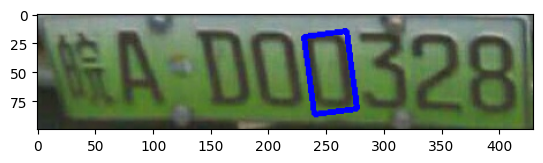

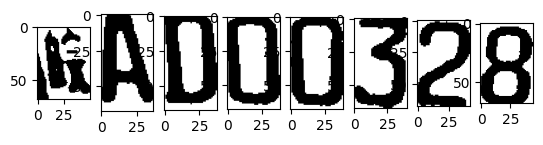

1/1 [==============================] - 0s 18ms/step
['浙']
1/1 [==============================] - 0s 19ms/step
['浙', 'A', 'D', '0', '0', '3', '2', '8']


In [48]:

def evaluate(index):


    #选择一个进行评测
    file_list=os.listdir(test_filefolder_path)
    predict_output=[]
    img_name=file_list[index]
    original_img,y_str=getBaseInf(test_filefolder_path,img_name)
    try:
        pre_border_removed_img,rot_img,draw_img,delete_img,gray_img,g=preSolveImgs(original_img)#预处理，得到去除边框的黑白图像。
    except:
        print("预处理失败，失败的车牌为",y_str)
        plt.imshow(original_img)
        plt.show()
        return
    num_blocks,img_histupbottom=segImgs(pre_border_removed_img)#进一步去除边框，并对图像进行划分。
    plt.imshow(draw_img,cmap='gray')
    plt.show()
    for index,block in enumerate(num_blocks):
        plt.subplot(1,len(num_blocks),index+1)
        plt.imshow(block,cmap='gray')
    plt.show()
    han_block=cv2.resize(num_blocks[0],(20,40),interpolation=cv2.INTER_LINEAR)
    han_block = han_block.reshape(1, 40, 20, 1)
    han_output = han_model.predict(han_block)
    predict_output.append(han_ver_dict[np.argmax(han_output)])
    print(predict_output)
    for i in range(len(num_blocks)-1):
        num_block=cv2.resize(num_blocks[i+1],(20,40),interpolation=cv2.INTER_LINEAR)
        num_block = num_block.reshape(1, 40, 20, 1)
        output = char_model.predict(num_block)
        predict_output.append(chr(np.argmax(output)+48))
    print(predict_output)
    return

evaluate(89)#更改此处，检查车牌识别情况


In [35]:
# import os
# train_filefolder_path='./train/'
# train_file_list = os.listdir(train_filefolder_path)
# han_head=set([])
# tmp_len=0
# for train_file_name in train_file_list:
#     han_head.add(train_file_name[0])
#     if(tmp_len<len(han_head)):
#         print(train_file_name)
#         tmp_len=len(han_head)


# print(han_head)


In [36]:


# #模型建立
# def conv2d_bn(inpt, filters=64, kernel_size=(3,3), strides=1, padding='same'):
#     '''卷积、归一化和relu三合一'''
#     x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(inpt)
#     x = layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

# def basic_bottle(inpt, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False):
#     '''18中的4个basic_bottle'''
#     x = conv2d_bn(inpt, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
#     x = conv2d_bn(x, filters=filters)
#     if if_baisc==True:
#         temp = conv2d_bn(inpt, filters=filters, kernel_size=(1,1), strides=2, padding='same')
#         outt = layers.add([x, temp])
#     else:
#         outt = layers.add([x, inpt])
#     return outt

# def resnet18(class_nums):
#     '''主模型'''
#     inpt = layers.Input(shape=(28,28,1))
#     #layer 1
#     x = conv2d_bn(inpt, filters=64, kernel_size=(7,7), strides=2, padding='valid')
#     x = layers.MaxPool2D(pool_size=(3,3), strides=2)(x)
#     #layer 2
#     x = basic_bottle(x, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False)
#     x = basic_bottle(x, filters=64, kernel_size=(3,3), strides=1, padding='same', if_baisc=False)
#     #layer 3
#     x = basic_bottle(x, filters=128, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
#     x = basic_bottle(x, filters=128, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
#     # layer 4
#     x = basic_bottle(x, filters=256, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
#     x = basic_bottle(x, filters=256, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
#     # layer 5
#     x = basic_bottle(x, filters=512, kernel_size=(3, 3), strides=2, padding='same', if_baisc=True)
#     x = basic_bottle(x, filters=512, kernel_size=(3, 3), strides=1, padding='same', if_baisc=False)
#     #GlobalAveragePool
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(class_nums, activation='softmax')(x)
#     model = tf.keras.Model(inputs=inpt, outputs=x)
#     return model

# #开始训练
# class_num = len(set(train_y))+1
# model = resnet18(class_num)
# model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
# model.fit(train_x, train_y, batch_size=64, epochs=10, validation_split=0.2) #epochs可以调的大一点，如果你机器好的话

# #验证结果
# pred_y = model.predict(test_x)
# last_pred = []
# for i in range(pred_y.shape[0]):
#     last_pred.append(pred_y[i].argmax())
# last_pred = np.array(last_pred)
# print(classification_report(test_y, last_pred))



In [37]:
# import matplotlib
# matplotlib.use('TkAgg')
# import cv2
# from matplotlib import pyplot as plt
# ## 根据每行和每列的黑色和白色像素数进行图片分割。

# path='./train/皖AD04222_01848_000.jpg'
# # 1、读取图像，并把图像转换为灰度图像并显示
# img_ = cv_imread(path)  # 读取图片
# img_gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)  # 转换了灰度化
# # cv2.imshow('gray', img_gray)  # 显示图片
# # cv2.waitKey(0)

# # 2、将灰度图像二值化，设定阈值是100
# ret, img_thre = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

# # 4、分割字符
# col_white = []  # 记录每一列的白色像素总和
# col_black = []  # ..........黑色.......
# height = img_thre.shape[0]
# img_width = img_thre.shape[1]
# col_white_max = 0
# col_black_max = 0
# # 计算每一列的黑白色像素总和
# for i in range(img_width):
#     s = 0  # 这一列白色总数
#     t = 0  # 这一列黑色总数
#     for j in range(height):
#         if img_thre[j][i] == 255:
#             s += 1
#         if img_thre[j][i] == 0:
#             t += 1
#     col_white_max = max(col_white_max, s)
#     col_black_max = max(col_black_max, t)
#     col_white.append(s)
#     col_black.append(t)
#     # print(s)
#     # print(t)

# arg = False  # False表示白底黑字；True表示黑底白字
# col_ratio=0.5

# # 分割图像
# def find_end(start_):
#     end_ = start_ + 1
#     for m in range(start_ + 1, img_width - 1):
#         if col_white[m] >  col_ratio * col_white_max:  # 0.95这个参数请多调整，对应下面的0.05（针对像素分布调节）
#             end_ = m
#             break
#     return end_

# n = 1
# start = 1
# end = 2
# word = []
# while n < img_width - 2:
#     n += 1
#     if col_black[n] > (1-col_ratio) * col_black_max:
#         # 上面这些判断用来辨别是白底黑字还是黑底白字
#         # 0.05这个参数请多调整，对应上面的0.95
#         start = n
#         end = find_end(start)
#         n = end
#         if end - start > 5:
#             cj = img_[1:height, start:end]
#             cj = cv2.resize(cj, (15, 30))
#             word.append(cj)

# print(len(word))
# %matplotlib inline
# for i,j in enumerate(word):
#     plt.subplot(1,8,i+1)
#     plt.imshow(word[i],cmap='gray')
# plt.show()

    